In [46]:
#testing reaction network code
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from diffrax import diffeqsolve, ODETerm, Tsit5, SaveAt
import optax  
import pickle as pkl
from reaction_nets import rxn_net
from functools import partial

In [ ]:
rxn=rxn_net('triangle_b')
t_points = jnp.linspace(0.0, 10.0, 200)

initial_params=jnp.array([0.5, 0.5, 0.5])
initial_conditions = jnp.log(jnp.array([1.5, 2, 0.5]))

n_samples=6

In [ ]:
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
all_features=jnp.array([-19, 19, 5, -5, 1, -1])#jax.random.uniform(subkey, (n_samples), minval=-20, maxval=20) 

#compute associated labels
a=(1 + jnp.tanh(0.4*(all_features - 7)))*0.4 + 0.1
c=(1 + jnp.tanh(-0.4*(all_features - 3)))*0.45
b=1-a-c

In [43]:
print(all_features)

[-19  19   5  -5]


In [44]:
solns=[]
for feature in all_features:
    all_params=jnp.append(initial_params, feature)
    solution = rxn.integrate(Tsit5(), t_points, dt0=0.01, initial_conditions=initial_conditions, args=all_params, max_steps=10000)
    solns.append(solution.ys.copy())

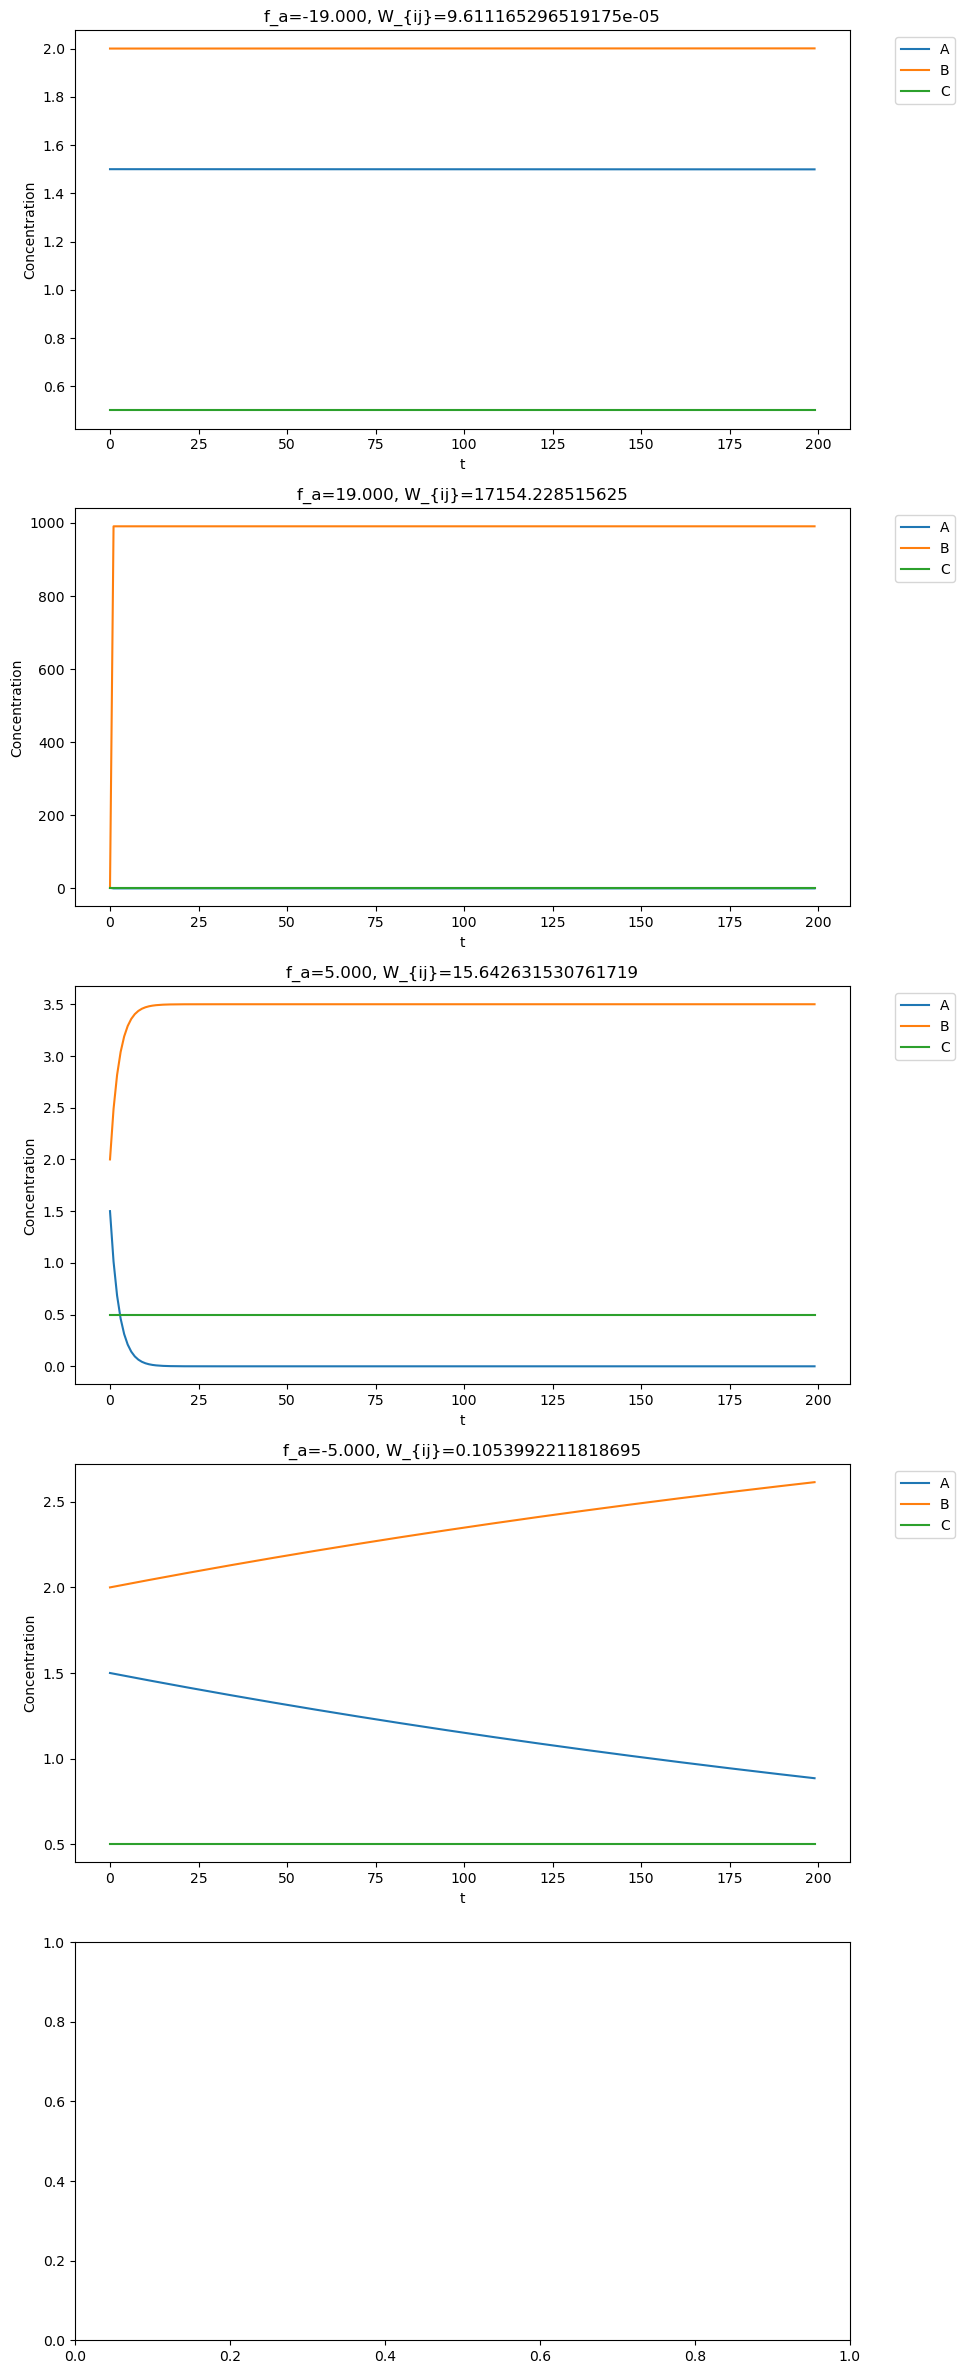

In [45]:
species_list=['A', 'B', 'C']
fig, ax=plt.subplots(n_samples, figsize=(10, 30))
for i, solution in enumerate(solns):
    for species, profile in zip(species_list, jnp.exp(solution.T)):
        ax[i].plot(profile, label=f'{species}')
    ax[i].set_xlabel('t')
    ax[i].set_ylabel('Concentration')
    ax[i].set_title(f'f_a={all_features[i]:0.3f}, W_{{ij}}={jnp.exp(initial_params[0] - initial_params[1] + 0.5*initial_params[2] + 0.5*all_features[i])}')
    ax[i].legend(bbox_to_anchor=[1.05, 1], loc='upper left')